Preparazione pacchetti

In [30]:
# ==============================================
# - BLOCCO 1 — Caricamento e unione dataset
# ==============================================
import os
import pandas as pd
import pyarrow.parquet as pq

DATASET_DIR = r"C:\Users\maria\Desktop\Zeek_ML\Final-Dataset"

all_dfs = []
for filename in os.listdir(DATASET_DIR):
    file_path = os.path.join(DATASET_DIR, filename)

    if filename.endswith(".csv"):
        print(f"[INFO] Caricamento CSV: {filename}")
        df = pd.read_csv(file_path)
        all_dfs.append(df)

    elif filename.endswith(".parquet"):
        print(f"[INFO] Caricamento PARQUET: {filename}")
        df = pd.read_parquet(file_path)
        all_dfs.append(df)

if not all_dfs:
    raise FileNotFoundError(f"Nessun file CSV o Parquet trovato in {DATASET_DIR}")

data_clean = pd.concat(all_dfs, ignore_index=True)
print(f"[INFO] Dataset combinato: {data_clean.shape[0]} righe, {data_clean.shape[1]} colonne")


[INFO] Caricamento PARQUET: part-00000-1da06990-329c-4e38-913a-0f0aa39b388d-c000.snappy.parquet
[INFO] Caricamento PARQUET: part-00000-23fdcfa3-9dd3-4c72-886c-e945bfcf92e1-c000.snappy.parquet
[INFO] Caricamento PARQUET: part-00000-26e9208e-7819-451b-b23f-2e47f6d1e834-c000.snappy.parquet
[INFO] Caricamento PARQUET: part-00000-2b76f9cc-0710-45e4-9e33-98ad5808ee79-c000.snappy.parquet
[INFO] Caricamento PARQUET: part-00000-36240b61-b84f-4164-a873-d7973e652780-c000.snappy.parquet
[INFO] Caricamento PARQUET: part-00000-3f86626a-1225-47f9-a5a2-0170b737e404-c000.snappy.parquet
[INFO] Caricamento PARQUET: part-00000-745e350a-da9e-4619-bd52-8cc23bb41ad5-c000.snappy.parquet
[INFO] Caricamento PARQUET: part-00000-7c2e9adb-5430-4792-a42b-10ff5bbd46e8-c000.snappy.parquet
[INFO] Caricamento CSV: part-00000-8c53ceaf-1fd1-4711-aa7d-26d0c5323dab-c000.csv
[INFO] Caricamento PARQUET: part-00000-94d13437-ae00-4a8c-9f38-edd0196cfdee-c000.snappy.parquet
[INFO] Caricamento PARQUET: part-00000-9a46dd05-4b06-4a

In [31]:
# ===============================================
# Esplorazione colonne e struttura dataset
# ===============================================

print("\n[INFO] ✅ Dataset combinato correttamente.")
print(f"Totale righe: {data_clean.shape[0]}")
print(f"Totale colonne: {data_clean.shape[1]}")

# 🔹 Mostra elenco completo delle colonne
print("\n[INFO] Elenco colonne:")
for i, col in enumerate(data_clean.columns, 1):
    print(f"{i:02d}. {col}")

# 🔹 Mostra prime righe del dataset
print("\n[INFO] Prime righe del dataset:")
display(data_clean.head())

# 🔹 Tipi di dati per ciascuna colonna
print("\n[INFO] Tipi di dati per colonna:")
print(data_clean.dtypes)

# 🔹 Controllo valori nulli
print("\n[INFO] Conteggio valori nulli per colonna:")
print(data_clean.isnull().sum())

# 🔹 Se esiste una colonna etichetta, mostra la distribuzione
possible_labels = [c for c in data_clean.columns if "label" in c.lower()]
if possible_labels:
    print("\n[INFO] Possibili colonne etichetta trovate:")
    for lbl in possible_labels:
        print(f" - {lbl}")
        print(data_clean[lbl].value_counts(dropna=False))
else:
    print("\n[INFO] Nessuna colonna contenente 'label' trovata.")



[INFO] ✅ Dataset combinato correttamente.
Totale righe: 19262879
Totale colonne: 42

[INFO] Elenco colonne:
01. resp_pkts
02. service
03. orig_ip_bytes
04. local_resp
05. missed_bytes
06. proto
07. duration
08. conn_state
09. dest_ip_zeek
10. orig_pkts
11. community_id
12. resp_ip_bytes
13. dest_port_zeek
14. orig_bytes
15. local_orig
16. datetime
17. history
18. resp_bytes
19. uid
20. src_port_zeek
21. ts
22. src_ip_zeek
23. label_tactic
24. label_technique
25. label_binary
26. 2021-12-12 - 2021-12-19
27. 2021-12-19 - 2021-12-26
28. 2021-12-26 - 2022-01-02
29. 2022-01-02 - 2022-01-09
30. 2022-08-28 - 2022-09-04
31. 2022-09-04 - 2022-09-11
32. 2022-09-11 - 2022-09-18
33. 2022-09-18 - 2022-09-25
34. 2022-09-25 - 2022-10-02
35. 2022-10-02 - 2022-10-09
36. 2022-10-09 - 2022-10-16
37. 2022-10-16 - 2022-10-23
38. 2022-10-23 - 2022-10-30
39. 2022-01-09 - 2022-01-16
40. 2022-01-16 - 2022-01-23
41. 2022-02-06 - 2022-02-13
42. 2022-02-13 - 2022-02-20

[INFO] Prime righe del dataset:


,resp_pkts,service,orig_ip_bytes,local_resp,missed_bytes,proto,duration,conn_state,dest_ip_zeek,orig_pkts,community_id,resp_ip_bytes,dest_port_zeek,orig_bytes,local_orig,datetime,history,resp_bytes,uid,src_port_zeek,ts,src_ip_zeek,label_tactic,label_technique,label_binary,2021-12-12 - 2021-12-19,2021-12-19 - 2021-12-26,2021-12-26 - 2022-01-02,2022-01-02 - 2022-01-09,2022-08-28 - 2022-09-04,2022-09-04 - 2022-09-11,2022-09-11 - 2022-09-18,2022-09-18 - 2022-09-25,2022-09-25 - 2022-10-02,2022-10-02 - 2022-10-09,2022-10-09 - 2022-10-16,2022-10-16 - 2022-10-23,2022-10-23 - 2022-10-30,2022-01-09 - 2022-01-16,2022-01-16 - 2022-01-23,2022-02-06 - 2022-02-13,2022-02-13 - 2022-02-20
0,2620.0,ssh,277936.0,False,44.0,tcp,4132.060737,S1,143.88.9.13,4032.0,1:SF+bnPlfAo1QfHTGTsIe/xQRIBY=,325680.0,22.0,17048.0,False,2022-02-19 12:18:28.457,ShADTadtTttTGtT,47316.0,Cg4R1LqazmXBKwYX2,45424.0,1.645273e+09,143.88.4.15,Defense Evasion,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2620.0,ssh,277936.0,False,44.0,tcp,4132.060737,S1,143.88.9.13,4032.0,1:SF+bnPlfAo1QfHTGTsIe/xQRIBY=,325680.0,22.0,17048.0,False,2022-02-19 12:18:28.457,ShADTadtTttTGtT,47316.0,Cg4R1LqazmXBKwYX2,45424.0,1.645273e+09,143.88.4.15,Initial Access,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2620.0,ssh,277936.0,False,44.0,tcp,4132.060737,S1,143.88.9.13,4032.0,1:SF+bnPlfAo1QfHTGTsIe/xQRIBY=,325680.0,22.0,17048.0,False,2022-02-19 12:18:28.457,ShADTadtTttTGtT,47316.0,Cg4R1LqazmXBKwYX2,45424.0,1.645273e+09,143.88.4.15,Persistence,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2620.0,ssh,277936.0,False,44.0,tcp,4132.060737,S1,143.88.9.13,4032.0,1:SF+bnPlfAo1QfHTGTsIe/xQRIBY=,325680.0,22.0,17048.0,False,2022-02-19 12:18:28.457,ShADTadtTttTGtT,47316.0,Cg4R1LqazmXBKwYX2,45424.0,1.645273e+09,143.88.4.15,Privilege Escalation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,64.0,ssh,11824.0,False,0.0,tcp,17.406988,SF,143.88.10.11,84.0,1:gN3opxvpYahDP9Ht9sShOEGODdc=,12048.0,22.0,1880.0,False,2022-02-18 10:16:57.899,ShADTadtTtFRf,2172.0,CIvLhX2VxjWEcHN66c,59554.0,1.645179e+09,143.88.5.17,Exfiltration,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



[INFO] Tipi di dati per colonna:
resp_pkts                         float64
service                            object
orig_ip_bytes                     float64
local_resp                         object
missed_bytes                      float64
proto                              object
duration                          float64
conn_state                         object
dest_ip_zeek                       object
orig_pkts                         float64
community_id                       object
resp_ip_bytes                     float64
dest_port_zeek                    float64
orig_bytes                        float64
local_orig                         object
datetime                   datetime64[ns]
history                            object
resp_bytes                        float64
uid                                object
src_port_zeek                     float64
ts                                float64
src_ip_zeek                        object
label_tactic                       object


In [32]:
# ==============================================
# 🧩 BLOCCO 2 — Pulizia e pre-processing base
# ==============================================
import numpy as np
from sklearn.preprocessing import LabelEncoder
import pickle

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)

# Colonne numeriche principali
numerical_cols = [
    'orig_bytes', 'resp_bytes', 'duration', 'orig_pkts',
    'resp_pkts', 'orig_ip_bytes', 'resp_ip_bytes', 'missed_bytes'
]

# 🔹 Rimozione colonne con >99% NaN
def get_high_null_columns(df, threshold=99.0):
    null_percent = (df.isna().sum() / len(df)) * 100
    return null_percent[null_percent > threshold].index.tolist()

cols_to_drop = get_high_null_columns(data_clean)
if cols_to_drop:
    data_clean = data_clean.drop(columns=cols_to_drop)
    print(f"[INFO] Colonne rimosse (>99% NaN): {cols_to_drop}")
else:
    print("[INFO] Nessuna colonna rimossa (>99% NaN)")

# 🔹 Riempimento valori numerici mancanti
global_means = data_clean[numerical_cols].mean()
data_clean[numerical_cols] = data_clean[numerical_cols].fillna(global_means).fillna(0)

# 🔹 Riempimento valori categorici mancanti
for col in data_clean.select_dtypes(include=['object']).columns:
    data_clean[col] = data_clean[col].fillna("unknown")

# 🔹 Filtra tattiche MITRE valide
valid_tactics = [
    "Reconnaissance", "Discovery", "Credential Access", "Privilege Escalation",
    "Exfiltration", "Lateral Movement", "Resource Development", "Initial Access",
    "Persistence", "Defense Evasion"
]
before_filter = len(data_clean)
data_clean = data_clean[data_clean['label_tactic'].isin(valid_tactics)]
after_filter = len(data_clean)
print(f"[INFO] Filtrati {before_filter - after_filter} record non MITRE")

# 🔹 Rimozione duplicati
key_cols = ['uid', 'ts', 'src_ip_zeek', 'dest_ip_zeek', 'src_port_zeek', 'dest_port_zeek']
if all(col in data_clean.columns for col in key_cols):
    data_clean = data_clean.drop_duplicates(subset=key_cols)
else:
    data_clean = data_clean.drop_duplicates()

print(f"[INFO] Dataset pulito: {data_clean.shape[0]} righe")

# 🔹 Label encoding
label_encoder_tactic = LabelEncoder()
data_clean['label_tactic_encoded'] = label_encoder_tactic.fit_transform(data_clean['label_tactic'])
SAVE_DIR = r"C:\Users\maria\Desktop\Zeek_ML\TrainTestSplit"
os.makedirs(SAVE_DIR, exist_ok=True)

with open(os.path.join(SAVE_DIR, "label_encoder_tactic.pkl"), "wb") as f:
    pickle.dump(label_encoder_tactic, f)
print(f"[INFO] LabelEncoder per 'label_tactic' salvato in {SAVE_DIR}")

label_encoder_technique = LabelEncoder()
data_clean['label_technique_encoded'] = label_encoder_technique.fit_transform(data_clean['label_technique'])

print(f"[INFO] Classi MITRE trovate: {list(label_encoder_tactic.classes_)}")
print(data_clean['label_tactic'].value_counts())


[INFO] Colonne rimosse (>99% NaN): ['2021-12-12 - 2021-12-19', '2021-12-19 - 2021-12-26', '2021-12-26 - 2022-01-02', '2022-01-02 - 2022-01-09', '2022-08-28 - 2022-09-04', '2022-09-04 - 2022-09-11', '2022-09-11 - 2022-09-18', '2022-09-18 - 2022-09-25', '2022-09-25 - 2022-10-02', '2022-10-02 - 2022-10-09', '2022-10-09 - 2022-10-16', '2022-10-16 - 2022-10-23', '2022-10-23 - 2022-10-30', '2022-01-09 - 2022-01-16', '2022-01-16 - 2022-01-23', '2022-02-06 - 2022-02-13', '2022-02-13 - 2022-02-20']
[INFO] Filtrati 9632038 record non MITRE
[INFO] Dataset pulito: 348396 righe
[INFO] LabelEncoder per 'label_tactic' salvato in C:\Users\maria\Desktop\Zeek_ML\TrainTestSplit
[INFO] Classi MITRE trovate: ['Credential Access', 'Defense Evasion', 'Discovery', 'Exfiltration', 'Initial Access', 'Lateral Movement', 'Persistence', 'Privilege Escalation', 'Reconnaissance', 'Resource Development']
label_tactic
Resource Development    262412
Reconnaissance           64908
Discovery                18106
Defense 

[INFO] Analisi outlier in corso...


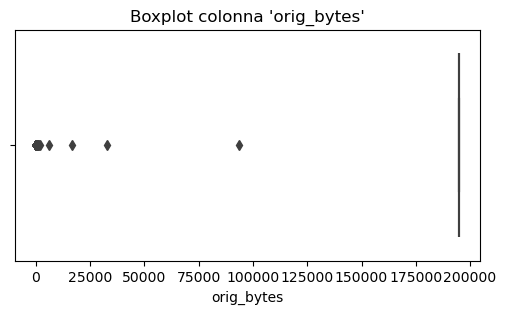

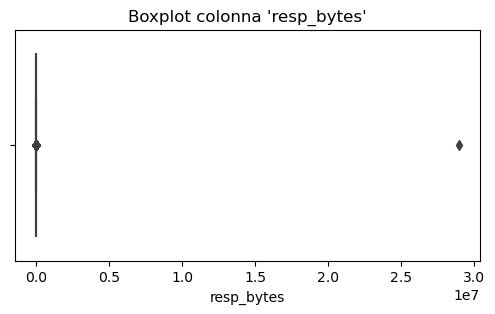

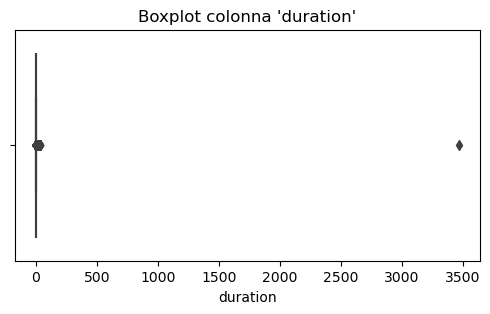

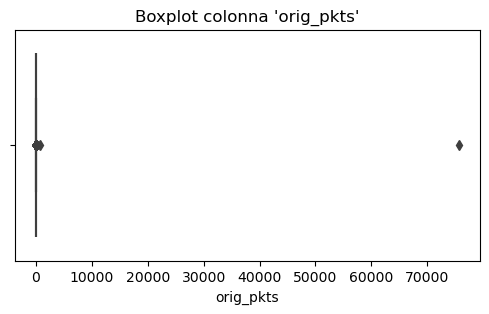

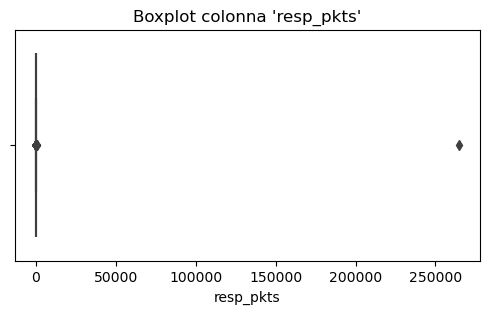

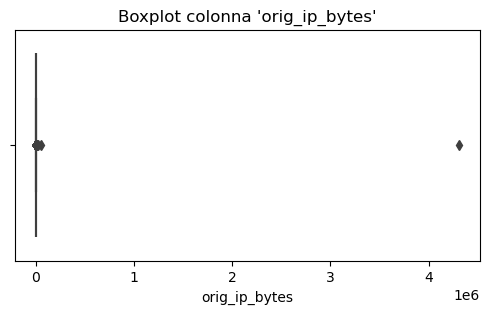

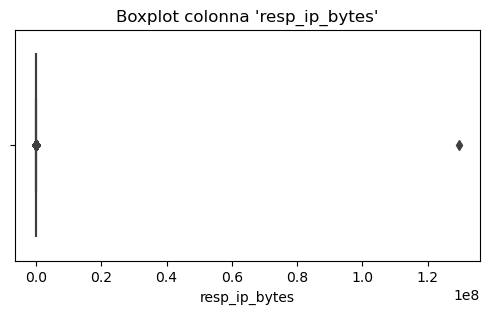

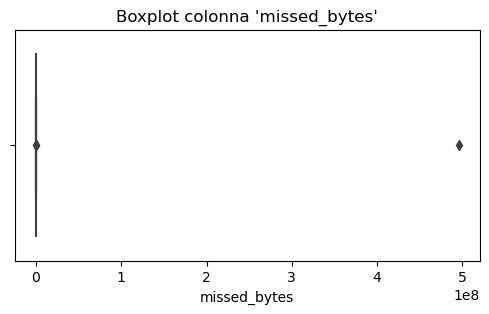

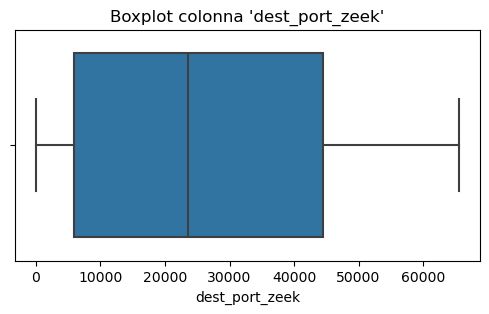

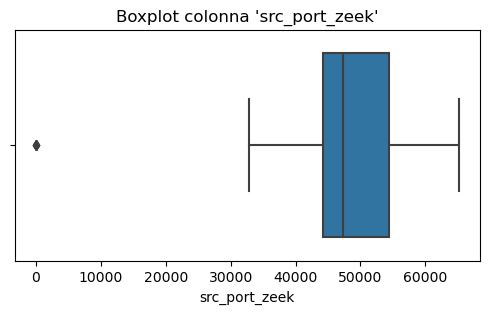

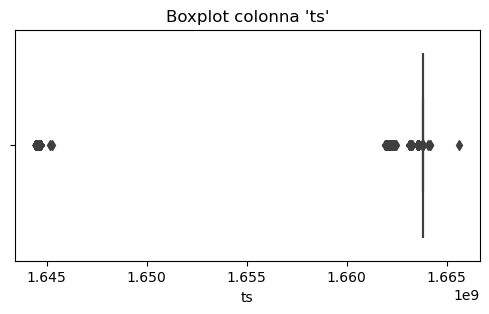

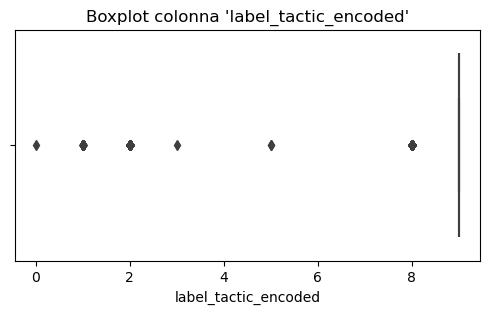

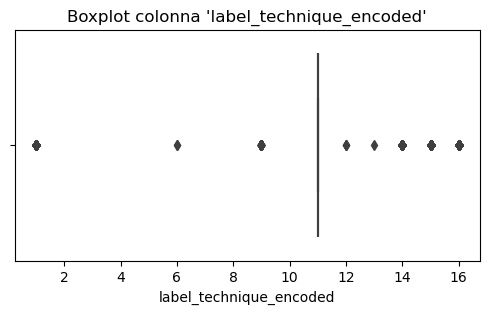

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


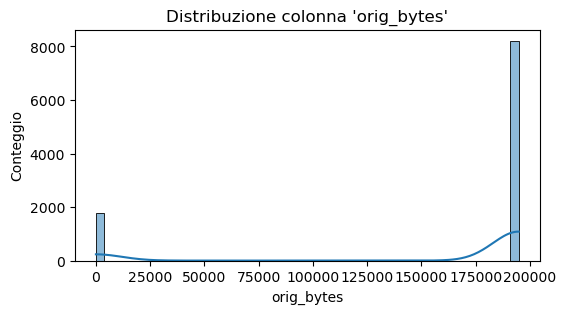

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


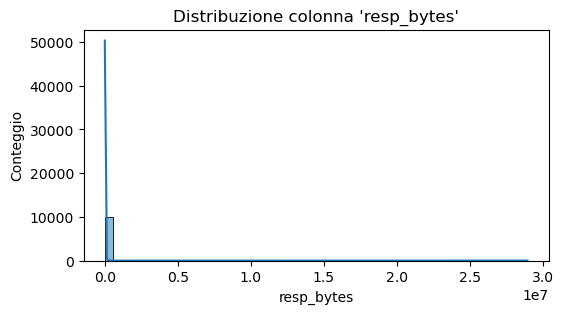

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


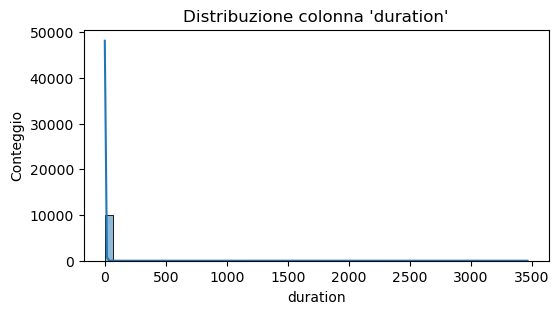

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


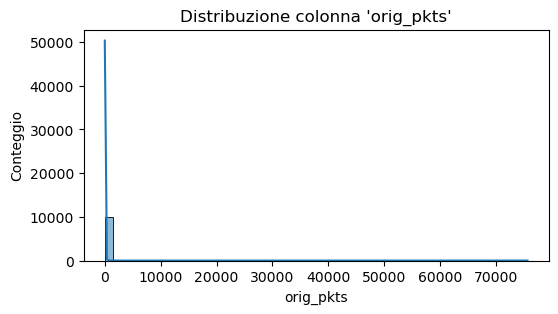

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


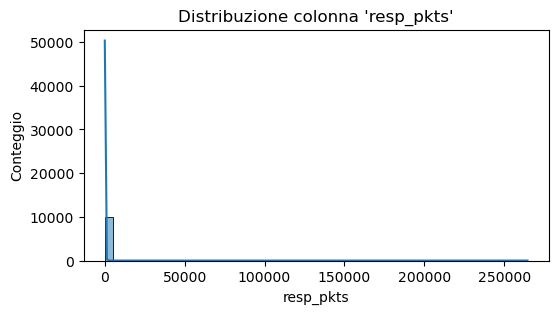

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


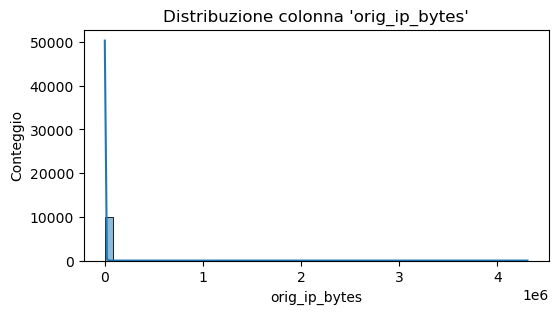

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


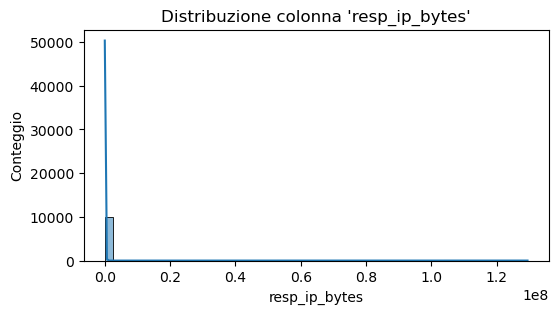

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


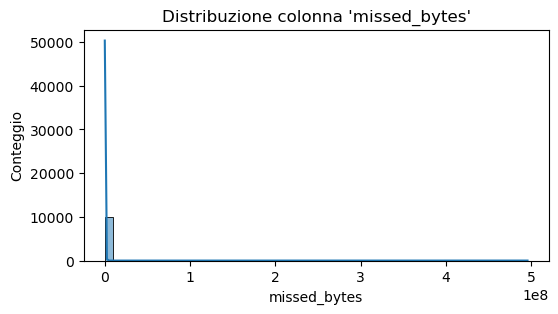

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


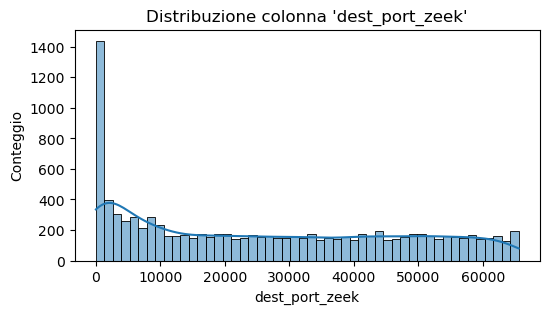

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


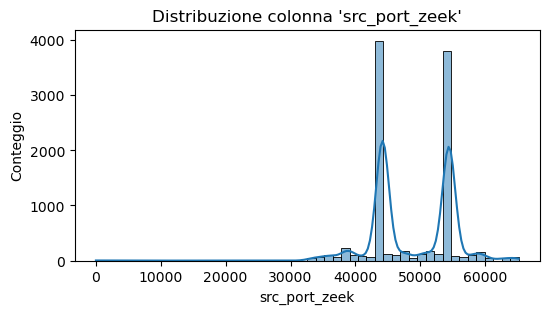

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


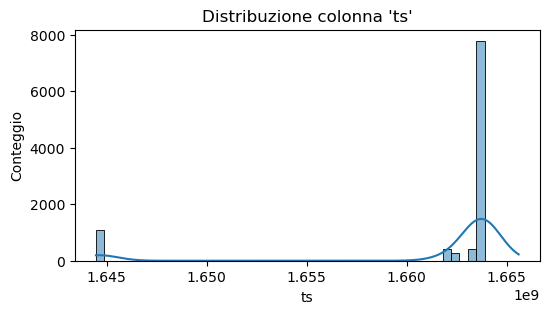

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


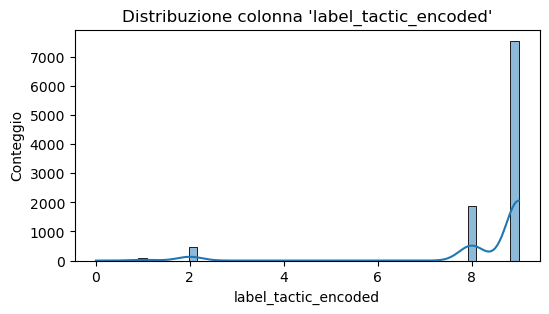

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


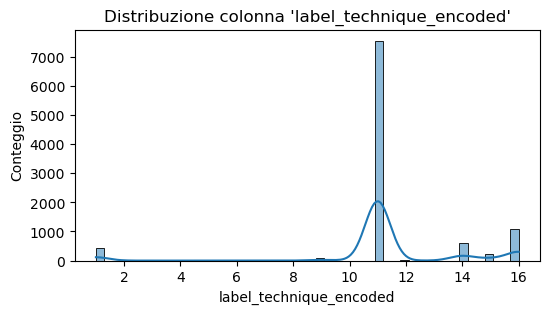

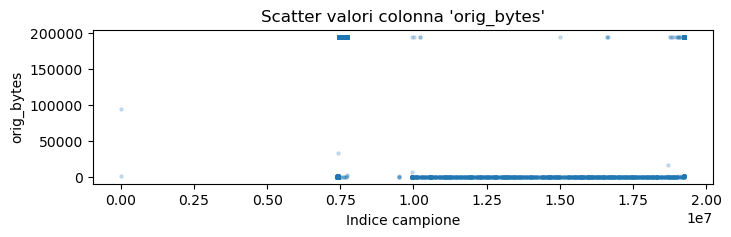

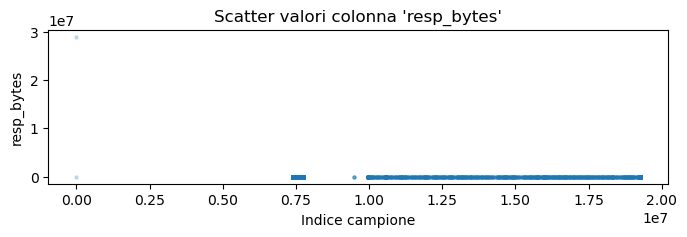

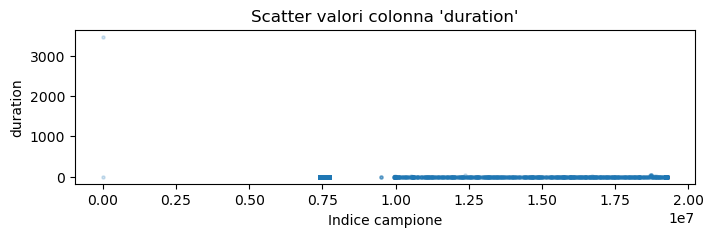

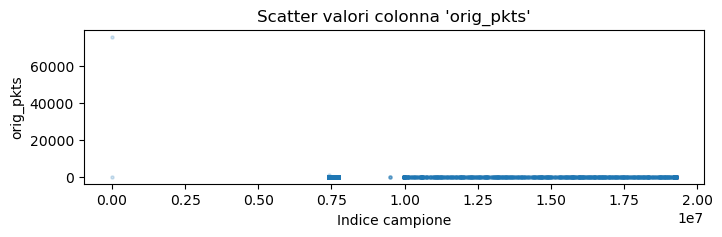

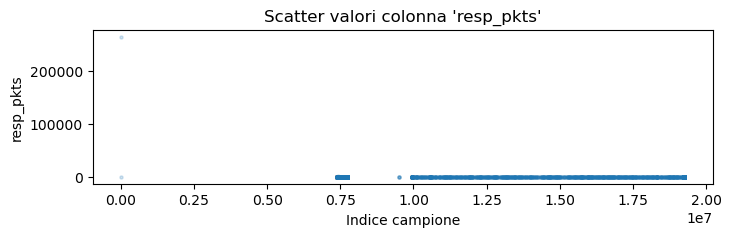

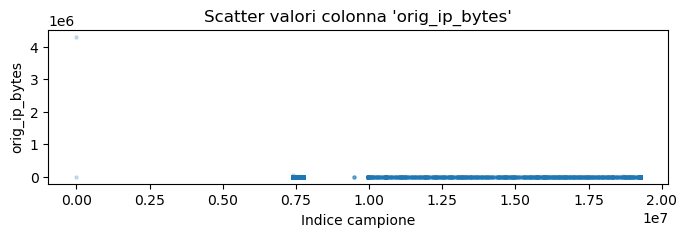

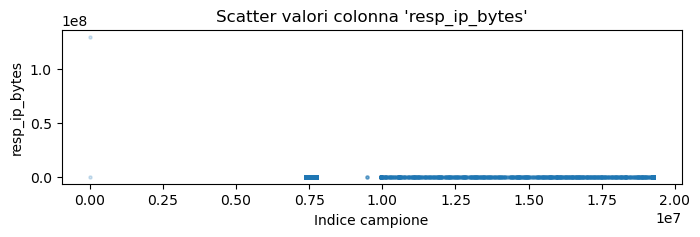

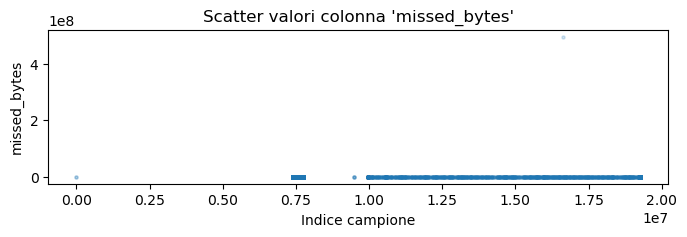

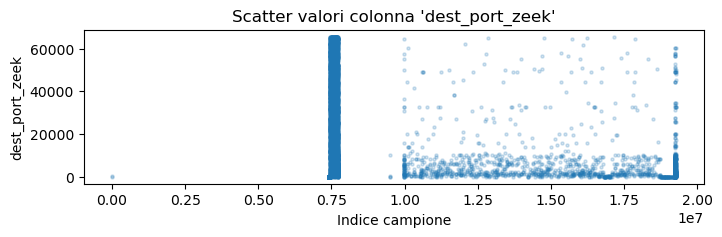

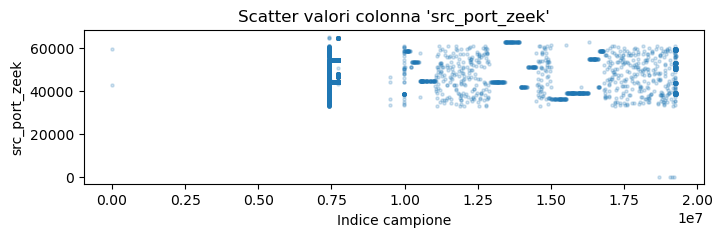

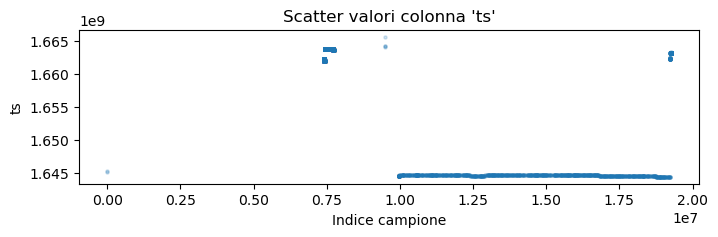

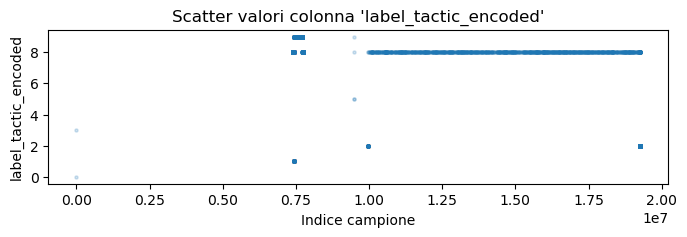

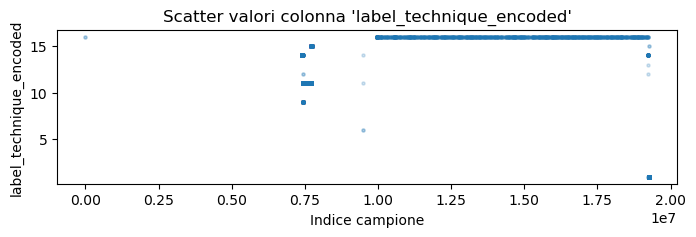

In [33]:
# ==============================================
# - BLOCCO 3 — Analisi e gestione outlier (aggiornato)
# ==============================================
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("[INFO] Analisi outlier in corso...")

# 🔹 Definire tutte le colonne numeriche che vogliamo analizzare, comprese le label encode
numeric_cols = [
    'orig_bytes', 'resp_bytes', 'duration', 'orig_pkts', 
    'resp_pkts', 'orig_ip_bytes', 'resp_ip_bytes', 'missed_bytes',
    'dest_port_zeek', 'src_port_zeek', 'ts', 
    'label_tactic_encoded', 'label_technique_encoded'
]

# 🔹 Campionamento per grafici (velocizza la visualizzazione)
sample_size = min(10000, len(data_clean))
sampled = data_clean[numeric_cols].sample(n=sample_size, random_state=42)

# 🔹 Gestione valori inf
sampled.replace([np.inf, -np.inf], np.nan, inplace=True)

# 1️⃣ Boxplot per colonna singola
for col in numeric_cols:
    plt.figure(figsize=(6,3))
    sns.boxplot(x=sampled[col])
    plt.title(f"Boxplot colonna '{col}'")
    plt.xlabel(col)
    plt.show()

# 2️⃣ Histogrammi con KDE
for col in numeric_cols:
    plt.figure(figsize=(6,3))
    sns.histplot(sampled[col], bins=50, kde=True)
    plt.title(f"Distribuzione colonna '{col}'")
    plt.xlabel(col)
    plt.ylabel("Conteggio")
    plt.show()

# 3️⃣ Scatter plot valori vs indice
for col in numeric_cols:
    plt.figure(figsize=(8,2))
    plt.scatter(sampled.index, sampled[col], alpha=0.2, s=5)
    plt.title(f"Scatter valori colonna '{col}'")
    plt.xlabel("Indice campione")
    plt.ylabel(col)
    plt.show()


In [34]:
# ==============================================
# - BLOCCO 4 — Gestione outlier per classe (versione sicura)
# ==============================================
import numpy as np
import pandas as pd

print("[INFO] Inizio gestione outlier per classe (versione sicura)...")

# 🔹 Copia dataset per sicurezza
data_preproc_list = []

# 🔹 Colonne numeriche da usare per la rimozione outlier
numerical_cols = [
    'orig_bytes', 'resp_bytes', 'duration', 'orig_pkts', 
    'resp_pkts', 'orig_ip_bytes', 'resp_ip_bytes', 'missed_bytes'
]

# 🔹 Conta righe iniziali
before_outlier_total = len(data_clean)

# 🔹 Loop per classe
for cls in sorted(data_clean['label_tactic_encoded'].unique()):
    df_class = data_clean[data_clean['label_tactic_encoded'] == cls].copy()
    n_rows = len(df_class)
    
    if n_rows < 5:
        # Classi troppo piccole → le manteniamo tutte
        data_preproc_list.append(df_class)
        print(f"[INFO] Classe {cls}: troppo piccola ({n_rows} righe), mantenuta interamente.")
        continue

    # Calcolo IQR su base di classe
    Q1 = df_class[numerical_cols].quantile(0.25)
    Q3 = df_class[numerical_cols].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filtraggio outlier su base per-colonna
    mask = ~((df_class[numerical_cols] < lower_bound) | 
             (df_class[numerical_cols] > upper_bound)).any(axis=1)
    df_filtered = df_class[mask]

    kept = len(df_filtered)
    removed = n_rows - kept
    print(f"[INFO] Classe {cls}: {kept}/{n_rows} righe mantenute ({removed} outlier rimossi)")

    data_preproc_list.append(df_filtered)

# 🔹 Combina tutte le classi ripulite
data_preproc = pd.concat(data_preproc_list, ignore_index=True)
after_outlier_total = len(data_preproc)

# 🔹 Riepilogo globale
print("\n[INFO] ✅ Gestione outlier completata.")
print(f"[INFO] Righe totali: {before_outlier_total} → {after_outlier_total} "
      f"({before_outlier_total - after_outlier_total} righe rimosse)")

print("\n[INFO] Distribuzione classi dopo outlier filtering:")
print(data_preproc['label_tactic_encoded'].value_counts().sort_index())


[INFO] Inizio gestione outlier per classe (versione sicura)...
[INFO] Classe 0: 19/29 righe mantenute (10 outlier rimossi)
[INFO] Classe 1: 2582/2895 righe mantenute (313 outlier rimossi)
[INFO] Classe 2: 15970/18106 righe mantenute (2136 outlier rimossi)
[INFO] Classe 3: 6/7 righe mantenute (1 outlier rimossi)
[INFO] Classe 4: 9/16 righe mantenute (7 outlier rimossi)
[INFO] Classe 5: 10/13 righe mantenute (3 outlier rimossi)
[INFO] Classe 6: 2/5 righe mantenute (3 outlier rimossi)
[INFO] Classe 7: 4/5 righe mantenute (1 outlier rimossi)
[INFO] Classe 8: 49428/64908 righe mantenute (15480 outlier rimossi)
[INFO] Classe 9: 262096/262412 righe mantenute (316 outlier rimossi)

[INFO] ✅ Gestione outlier completata.
[INFO] Righe totali: 348396 → 330126 (18270 righe rimosse)

[INFO] Distribuzione classi dopo outlier filtering:
label_tactic_encoded
0        19
1      2582
2     15970
3         6
4         9
5        10
6         2
7         4
8     49428
9    262096
Name: count, dtype: int64


In [35]:
# ==============================================
# 🧩 BLOCCO 4.5 — Bilanciamento controllato + report completo
# ==============================================
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd

print("[INFO] Inizio bilanciamento controllato (Opzione A)...")

df = data_preproc.copy()

# =========================
# 1️⃣ Report iniziale
# =========================
label_counts = df['label_tactic_encoded'].value_counts().sort_index()
total = len(df)
report_init = pd.DataFrame({
    'Classe': label_counts.index,
    'Campioni': label_counts.values,
    'Percentuale': (label_counts.values / total * 100).round(2)
})
print("\n[REPORT INIZIALE DISTRIBUZIONE CLASSI]")
display(report_init)

# =========================
# 2️⃣ Definizione soglie target
# =========================
# Target personalizzati (ispirato alla tua tabella)
target_sizes = {
    9: 25000,  # classi enormi → tagliate
    8: 25000,
    2: 16000,  # classi medie → mantenute
    1: 8000,   # classe piccola → SMOTE moderato
}

min_smote_size = 200  # target minimo per classi minuscole
max_smote_size = 400  # target massimo per micro-classi
max_smote_allowed = 8000  # evita oversampling eccessivo

df_balanced_parts = []
skipped_classes = []

# =========================
# 3️⃣ Riduzione e SMOTE per classe
# =========================
for cls, count in label_counts.items():
    df_cls = df[df['label_tactic_encoded'] == cls]

    # Caso 1 → taglio per classi grandi
    if cls in target_sizes and count > target_sizes[cls]:
        df_cls = df_cls.sample(n=target_sizes[cls], random_state=42)
        print(f"[INFO] Classe {cls}: ridotta da {count} → {target_sizes[cls]}")
        df_balanced_parts.append(df_cls)

    # Caso 2 → classi medie → manteniamo
    elif 2000 <= count <= target_sizes.get(cls, count):
        print(f"[INFO] Classe {cls}: mantenuta ({count} righe)")
        df_balanced_parts.append(df_cls)

    # Caso 3 → classi molto piccole → SMOTE
    elif count < 2000:
        X = df_cls.drop(columns=['label_tactic_encoded'])
        y = df_cls['label_tactic_encoded']

        target_n = min(max_smote_size, max_smote_allowed)
        try:
            smote = SMOTE(sampling_strategy={cls: target_n}, random_state=42, k_neighbors=min(5, len(df_cls)-1))
            X_res, y_res = smote.fit_resample(X, y)
            df_smoted = pd.concat([X_res, y_res], axis=1)
            df_balanced_parts.append(df_smoted)
            print(f"[INFO] Classe {cls}: aumentata da {count} → {len(df_smoted)} (SMOTE)")
        except ValueError as e:
            skipped_classes.append((cls, count, str(e)))
            df_balanced_parts.append(df_cls)
            print(f"[WARN] Classe {cls}: SMOTE saltato ({count} righe) → {e}")

    else:
        # Mantieni classi già bilanciate o intermedie
        df_balanced_parts.append(df_cls)
        print(f"[INFO] Classe {cls}: mantenuta (no azione)")

# =========================
# 4️⃣ Combina dataset bilanciato
# =========================
df_balanced = pd.concat(df_balanced_parts, ignore_index=True)
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# =========================
# 5️⃣ Report finale
# =========================
label_counts_final = df_balanced['label_tactic_encoded'].value_counts().sort_index()
total_final = len(df_balanced)

report_final = pd.DataFrame({
    'Classe': label_counts_final.index,
    'Campioni_iniziali': report_init.set_index('Classe')['Campioni'],
    'Campioni_finali': label_counts_final.values,
    'Variazione_%': ((label_counts_final.values - report_init.set_index('Classe')['Campioni']) /
                     report_init.set_index('Classe')['Campioni'] * 100).round(2)
}).reset_index(drop=True)

print("\n[REPORT FINALE BILANCIAMENTO]")
display(report_final)

print(f"\n[INFO] Dataset finale bilanciato: {total} → {total_final} righe")
print(f"[INFO] Classi finali: {label_counts_final.to_dict()}")

if skipped_classes:
    print("\n⚠️ Classi per cui SMOTE è stato saltato:")
    for cls, n, reason in skipped_classes:
        print(f" - Classe {cls} ({n} campioni): {reason}")

# ✅ Pronto per la fase successiva
data_balanced = df_balanced.copy()


[INFO] Inizio bilanciamento controllato (Opzione A)...

[REPORT INIZIALE DISTRIBUZIONE CLASSI]


,Classe,Campioni,Percentuale
0,0,19,0.01
1,1,2582,0.78
2,2,15970,4.84
3,3,6,0.00
4,4,9,0.00
5,5,10,0.00
6,6,2,0.00
7,7,4,0.00
8,8,49428,14.97
9,9,262096,79.39


[WARN] Classe 0: SMOTE saltato (19 righe) → could not convert string to float: 'ftp'
[INFO] Classe 1: mantenuta (2582 righe)
[INFO] Classe 2: mantenuta (15970 righe)
[WARN] Classe 3: SMOTE saltato (6 righe) → could not convert string to float: 'ssh'
[WARN] Classe 4: SMOTE saltato (9 righe) → could not convert string to float: 'http'
[WARN] Classe 5: SMOTE saltato (10 righe) → could not convert string to float: 'unknown'
[WARN] Classe 6: SMOTE saltato (2 righe) → could not convert string to float: 'unknown'
[WARN] Classe 7: SMOTE saltato (4 righe) → could not convert string to float: 'unknown'
[INFO] Classe 8: ridotta da 49428 → 25000
[INFO] Classe 9: ridotta da 262096 → 25000

[REPORT FINALE BILANCIAMENTO]


,Classe,Campioni_iniziali,Campioni_finali,Variazione_%
0,0,19,19,0.00
1,1,2582,2582,0.00
2,2,15970,15970,0.00
3,3,6,6,0.00
4,4,9,9,0.00
5,5,10,10,0.00
6,6,2,2,0.00
7,7,4,4,0.00
8,8,49428,25000,-49.42
9,9,262096,25000,-90.46



[INFO] Dataset finale bilanciato: 330126 → 68602 righe
[INFO] Classi finali: {0: 19, 1: 2582, 2: 15970, 3: 6, 4: 9, 5: 10, 6: 2, 7: 4, 8: 25000, 9: 25000}

⚠️ Classi per cui SMOTE è stato saltato:
 - Classe 0 (19 campioni): could not convert string to float: 'ftp'
 - Classe 3 (6 campioni): could not convert string to float: 'ssh'
 - Classe 4 (9 campioni): could not convert string to float: 'http'
 - Classe 5 (10 campioni): could not convert string to float: 'unknown'
 - Classe 6 (2 campioni): could not convert string to float: 'unknown'
 - Classe 7 (4 campioni): could not convert string to float: 'unknown'


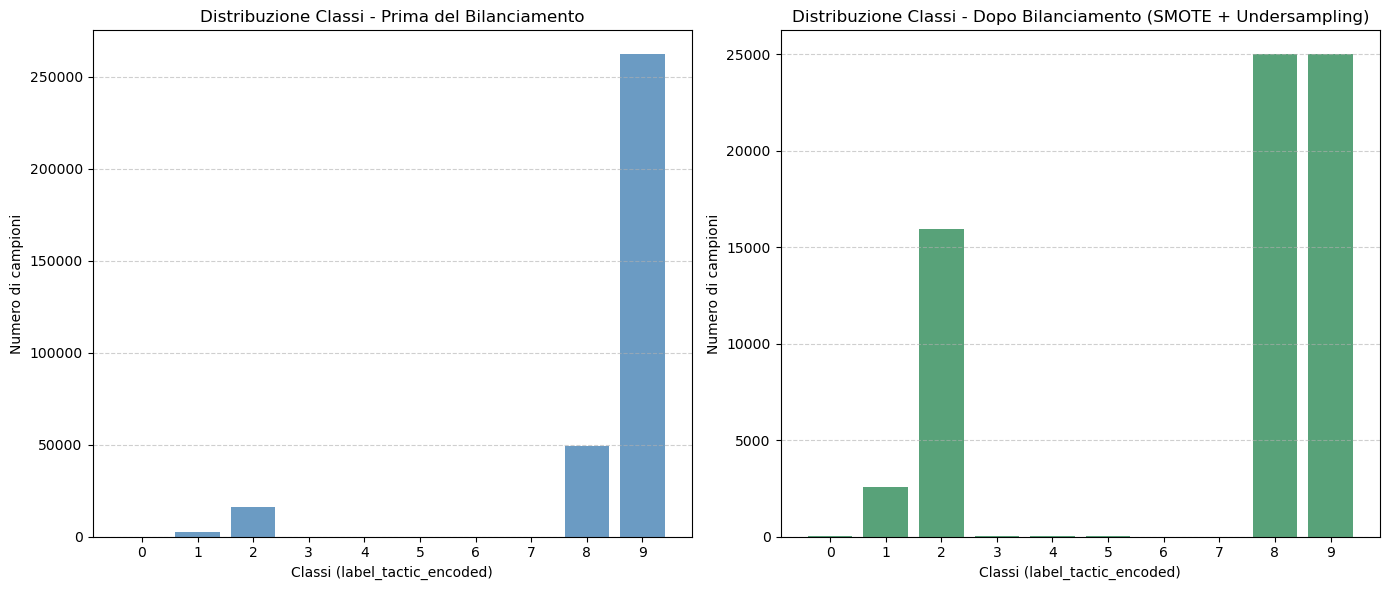

In [36]:
# ============================================
# 🧩 BLOCCO 4.6 - Visualizzazione grafica bilanciamento classi
# ============================================
import matplotlib.pyplot as plt

# Dati prima/dopo
class_counts = df['label_tactic_encoded'].value_counts().sort_index()
final_counts = df_balanced['label_tactic_encoded'].value_counts().sort_index()

plt.figure(figsize=(14, 6))

# Grafico 1 - Prima
plt.subplot(1, 2, 1)
plt.bar(class_counts.index, class_counts.values, color='steelblue', alpha=0.8)
plt.title("Distribuzione Classi - Prima del Bilanciamento")
plt.xlabel("Classi (label_tactic_encoded)")
plt.ylabel("Numero di campioni")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(class_counts.index)

# Grafico 2 - Dopo
plt.subplot(1, 2, 2)
plt.bar(final_counts.index, final_counts.values, color='seagreen', alpha=0.8)
plt.title("Distribuzione Classi - Dopo Bilanciamento (SMOTE + Undersampling)")
plt.xlabel("Classi (label_tactic_encoded)")
plt.ylabel("Numero di campioni")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(final_counts.index)

plt.tight_layout()
plt.show()


In [37]:
# ==============================================
# 🔹 BLOCCO 5 — Feature Engineering e Scaling
# ==============================================
from sklearn.preprocessing import RobustScaler, LabelEncoder
import numpy as np
import pandas as pd

print("[INFO] Inizio feature engineering e scaling (versione robusta)...")

# 🔹 Copia del dataset bilanciato
data_preproc = df_balanced.copy()

# 🔹 Salva il target separatamente (NON SCALARE)
y_target = data_preproc['label_tactic_encoded'].copy()

# 🔹 Identifica colonne numeriche e categoriche (escludendo label)
numerical_cols = data_preproc.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols = [c for c in numerical_cols if c != 'label_tactic_encoded']

categorical_cols = data_preproc.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols = [c for c in categorical_cols if c not in ['label_tactic','label_technique']]

print(f"[INFO] Colonne numeriche: {len(numerical_cols)} | Colonne categoriche: {len(categorical_cols)}")

# 🔹 Scaling numerico
scaler = RobustScaler()
data_preproc[numerical_cols] = scaler.fit_transform(data_preproc[numerical_cols])
print("[INFO] Scaling numerico completato (RobustScaler)")

# 🔹 Encoding categoriche
max_categories = 20
low_card_cols = [c for c in categorical_cols if data_preproc[c].nunique() <= max_categories]
high_card_cols = [c for c in categorical_cols if c not in low_card_cols]

print(f"[INFO] One-hot su colonne low-cardinality: {low_card_cols}")
print(f"[INFO] Label encoding su colonne high-cardinality: {high_card_cols}")

if low_card_cols:
    dummies = pd.get_dummies(data_preproc[low_card_cols], drop_first=True, dtype=int)
    data_preproc = pd.concat([data_preproc.drop(columns=low_card_cols), dummies], axis=1)
    print("[INFO] One-hot encoding completato")

for col in high_card_cols:
    le = LabelEncoder()
    data_preproc[col] = le.fit_transform(data_preproc[col].astype(str))
    print(f"[INFO] Label encoding su '{col}' completato")

# 🔹 Reintroduci il target alla fine
data_preproc['label_tactic_encoded'] = y_target

print(f"[INFO] Dataset finale preprocessing: {data_preproc.shape[0]} righe, {data_preproc.shape[1]} colonne totali.")


[INFO] Inizio feature engineering e scaling (versione robusta)...
[INFO] Colonne numeriche: 12 | Colonne categoriche: 11
[INFO] Scaling numerico completato (RobustScaler)
[INFO] One-hot su colonne low-cardinality: ['service', 'local_resp', 'proto', 'conn_state', 'local_orig', 'src_ip_zeek', 'label_binary']
[INFO] Label encoding su colonne high-cardinality: ['dest_ip_zeek', 'community_id', 'history', 'uid']
[INFO] One-hot encoding completato
[INFO] Label encoding su 'dest_ip_zeek' completato
[INFO] Label encoding su 'community_id' completato
[INFO] Label encoding su 'history' completato
[INFO] Label encoding su 'uid' completato
[INFO] Dataset finale preprocessing: 68602 righe, 57 colonne totali.


[INFO] Inizio analisi correlazioni e PCA...


c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


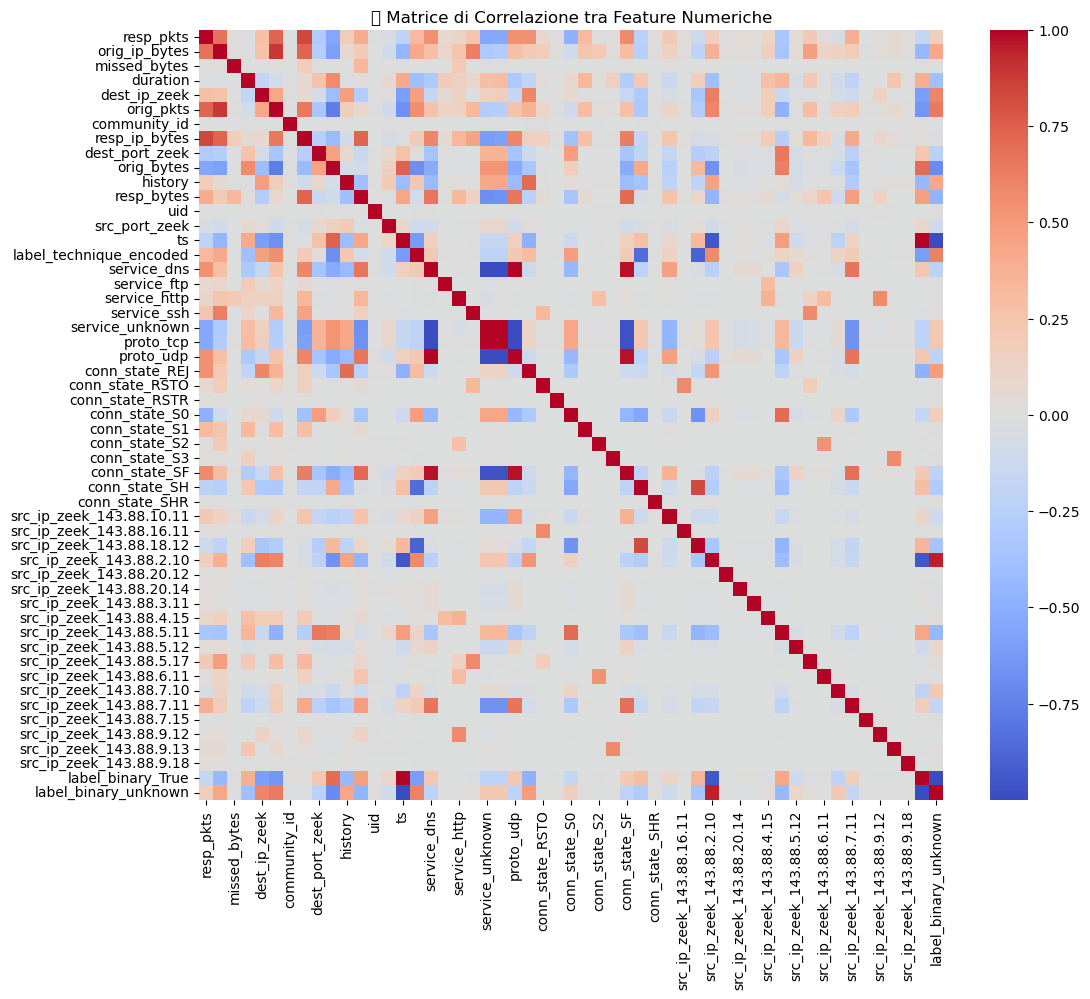

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


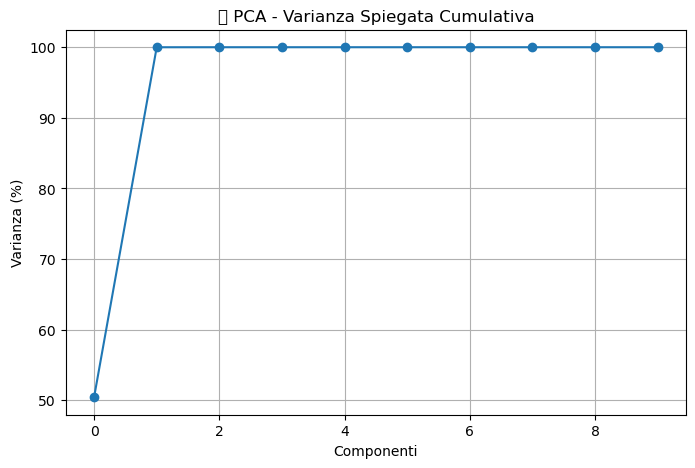

In [38]:
# ==============================================
# 🧩 BLOCCO 6 — Analisi delle correlazioni e PCA
# ==============================================
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd

print("[INFO] Inizio analisi correlazioni e PCA...")

num_cols = [c for c in data_preproc.select_dtypes(include=[np.number]).columns if c != 'label_tactic_encoded']
corr_matrix = data_preproc[num_cols].corr().fillna(0)

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0)
plt.title("🔍 Matrice di Correlazione tra Feature Numeriche")
plt.show()

pca = PCA(n_components=min(10, len(num_cols)), random_state=42)
pca_result = pca.fit_transform(data_preproc[num_cols])
explained = pca.explained_variance_ratio_ * 100

plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(explained), marker='o')
plt.title("📈 PCA - Varianza Spiegata Cumulativa")
plt.xlabel("Componenti")
plt.ylabel("Varianza (%)")
plt.grid(True)
plt.show()


In [ ]:
# ==============================================
# 🧩 BLOCCO 7 — Feature Selection Avanzata (Fix datetime)
# ==============================================
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

print("[INFO] Inizio feature selection avanzata...")

# 🔹 Separa feature e target
X = data_preproc.drop(columns=['label_tactic_encoded', 'label_tactic', 'label_technique'], errors='ignore')
y = y_target  # target non scalato

# 🔹 Gestione NaN e infiniti
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

# =====================================================
# 🔍 Filtra solo colonne numeriche (evita errori dtype)
# =====================================================
non_numeric_cols = X.select_dtypes(exclude=['number']).columns.tolist()
if non_numeric_cols:
    print(f"[WARN] Rilevate {len(non_numeric_cols)} colonne non numeriche, saranno escluse:")
    for c in non_numeric_cols:
        print(f"   - {c}")
X = X.select_dtypes(include=['number'])

# =====================================================
# 1️⃣ Rimuove feature a varianza nulla
# =====================================================
sel = VarianceThreshold(threshold=0)
X = pd.DataFrame(sel.fit_transform(X), columns=np.array(X.columns)[sel.get_support()])

# =====================================================
# 2️⃣ ANOVA F-test
# =====================================================
anova_selector = SelectKBest(f_classif, k='all')
anova_selector.fit(X, y)
anova_scores = pd.DataFrame({'Feature': X.columns, 'ANOVA_F': anova_selector.scores_})

# =====================================================
# 3️⃣ Mutual Information
# =====================================================
mi_scores = mutual_info_classif(X, y, random_state=42)
mi_scores_df = pd.DataFrame({'Feature': X.columns, 'Mutual_Info': mi_scores})

# =====================================================
# 4️⃣ Random Forest Feature Importance
# =====================================================
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X, y)
rf_imp = pd.DataFrame({'Feature': X.columns, 'RF_Importance': rf.feature_importances_})

# =====================================================
# 🔹 Combina risultati in unico ranking
# =====================================================
feature_rank = (
    anova_scores
    .merge(mi_scores_df, on='Feature')
    .merge(rf_imp, on='Feature')
)

# Normalizzazione (0–1)
for col in ['ANOVA_F', 'Mutual_Info', 'RF_Importance']:
    feature_rank[col] = (
        (feature_rank[col] - feature_rank[col].min()) /
        (feature_rank[col].max() - feature_rank[col].min())
    )

feature_rank['Combined_Score'] = (
    0.4 * feature_rank['RF_Importance'] +
    0.3 * feature_rank['Mutual_Info'] +
    0.3 * feature_rank['ANOVA_F']
)

# =====================================================
# 🔹 Visualizza Top 20
# =====================================================
top_features = feature_rank.sort_values(by='Combined_Score', ascending=False).head(20)

plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Combined_Score'], color='royalblue')
plt.gca().invert_yaxis()
plt.title("🏆 Top 20 Feature per Importanza Combinata")
plt.xlabel("Punteggio normalizzato")
plt.tight_layout()
plt.show()

print("\n[INFO] ✅ Top 10 feature selezionate:")
print(top_features[['Feature', 'Combined_Score']].round(3))


[INFO] Inizio feature selection avanzata...


DTypePromotionError: The DType <class 'numpy.dtypes.DateTime64DType'> could not be promoted by <class 'numpy.dtypes.Float64DType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>)

In [ ]:
# ==============================================
# - BLOCCO 7.5 — Validazione post-feature selection
# ==============================================
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

print("[INFO] Avvio validazione post-feature selection...")

# 🔹 Usa un classificatore base per confronto (Random Forest)
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced_subsample'
)

# 🔹 Confronta prestazioni pre- e post-feature selection
print("[INFO] Valutazione con tutte le feature...")
scores_full = cross_val_score(rf, X, y, cv=5, scoring='accuracy')
print(f" - Media accuracy (tutte le feature): {scores_full.mean():.4f} ± {scores_full.std():.4f}")

top_features_list = feature_rank['Feature'].head(15).tolist()
X_top = X[top_features_list]

print("[INFO] Valutazione con feature selezionate...")
scores_top = cross_val_score(rf, X_top, y, cv=5, scoring='accuracy')
print(f" - Media accuracy (top feature): {scores_top.mean():.4f} ± {scores_top.std():.4f}")

delta = (scores_top.mean() - scores_full.mean()) * 100
trend = "miglioramento ✅" if delta > 0 else "leggero calo ⚠️"
print(f"[INFO] Differenza media: {delta:.2f}% → {trend}")

print("""
📊 NOTE:
- L’obiettivo non è massimizzare l’accuracy qui, ma verificare che la selezione non riduca troppo la capacità predittiva.
- Se la variazione è minima (<2%), la riduzione di feature è considerata accettabile.
""")


In [ ]:
# ==============================================
# - BLOCCO 8 — Train-Test Split + Salvataggio CSV
# ==============================================
from sklearn.model_selection import train_test_split
import os

print("[INFO] Suddivisione Train/Test e salvataggio in corso...")

# 🔹 Seleziona solo le top feature desiderate
top_features_list = feature_rank['Feature'].head(15).tolist()
X_selected = X[top_features_list]

# 🔹 Suddivisione Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

# 🔹 Crea una cartella per salvare i dataset
SAVE_DIR = r"C:\Users\maria\Desktop\Zeek_ML\TrainTestSplit"
os.makedirs(SAVE_DIR, exist_ok=True)

# 🔹 Salva i dataset in formato CSV
X_train_path = os.path.join(SAVE_DIR, "X_train.csv")
X_test_path  = os.path.join(SAVE_DIR, "X_test.csv")
y_train_path = os.path.join(SAVE_DIR, "y_train.csv")
y_test_path  = os.path.join(SAVE_DIR, "y_test.csv")

X_train.to_csv(X_train_path, index=False)
X_test.to_csv(X_test_path, index=False)
y_train.to_csv(y_train_path, index=False)
y_test.to_csv(y_test_path, index=False)

print(f"[INFO] ✅ Train/Test split completato e salvato in:\n"
      f" - {X_train_path}\n"
      f" - {X_test_path}\n"
      f" - {y_train_path}\n"
      f" - {y_test_path}")

print(f"[INFO] Dataset pronto per il training: {X_train.shape[0]} train / {X_test.shape[0]} test")


[INFO] Suddivisione Train/Test e salvataggio in corso...
[INFO] ✅ Train/Test split completato e salvato in:
 - C:\Users\maria\Desktop\Zeek_ML\TrainTestSplit\X_train.csv
 - C:\Users\maria\Desktop\Zeek_ML\TrainTestSplit\X_test.csv
 - C:\Users\maria\Desktop\Zeek_ML\TrainTestSplit\y_train.csv
 - C:\Users\maria\Desktop\Zeek_ML\TrainTestSplit\y_test.csv
[INFO] Dataset pronto per il training: 94141 train / 23536 test


In [ ]:
# ============================================== 
# - BLOCCO 9 — Binning e Scaling per modelli 
# ============================================== 

from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
import joblib
import pandas as pd
import numpy as np
import os

print("[INFO] Inizio trasformazioni: binning e scaling (versione ottimizzata)...")

# 🔹 Percorsi dei file già salvati 
SAVE_DIR = r"C:\Users\maria\Desktop\Zeek_ML\TrainTestSplit" 
X_train = pd.read_csv(os.path.join(SAVE_DIR, "X_train.csv")) 
X_test  = pd.read_csv(os.path.join(SAVE_DIR, "X_test.csv")) 
y_train = pd.read_csv(os.path.join(SAVE_DIR, "y_train.csv")) 
y_test  = pd.read_csv(os.path.join(SAVE_DIR, "y_test.csv")) 

# =================================================== 
# 1️⃣ BINNING (per NB, DT, RF)
# =================================================== 
n_bins = min(15, max(5, int(X_train.shape[0] ** 0.25)))  # dinamico in base ai dati
discretizer = KBinsDiscretizer(
    n_bins=n_bins,
    encode='ordinal',
    strategy='quantile'  # oppure 'kmeans' per distribuzioni multimodali
)

X_train_binned = discretizer.fit_transform(X_train)
X_test_binned  = discretizer.transform(X_test)

X_train_binned = pd.DataFrame(X_train_binned, columns=X_train.columns)
X_test_binned  = pd.DataFrame(X_test_binned,  columns=X_test.columns)

print(f"[INFO] ✅ Binning completato ({n_bins} bin, strategia='quantile')")
print(f" - X_train_binned shape: {X_train_binned.shape}")
print(f" - X_test_binned shape: {X_test_binned.shape}")

# =================================================== 
# 2️⃣ SCALING (per SVM, LogisticRegression)
# =================================================== 
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled  = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

print("[INFO] ✅ Scaling completato (StandardScaler)")
print(f" - X_train_scaled shape: {X_train_scaled.shape}")
print(f" - X_test_scaled shape: {X_test_scaled.shape}")

# =================================================== 
# 3️⃣ Salvataggio versioni trasformate + oggetti
# =================================================== 
np.save(os.path.join(SAVE_DIR, "X_train_binned.npy"), X_train_binned.values)
np.save(os.path.join(SAVE_DIR, "X_test_binned.npy"),  X_test_binned.values)
np.save(os.path.join(SAVE_DIR, "X_train_scaled.npy"), X_train_scaled.values)
np.save(os.path.join(SAVE_DIR, "X_test_scaled.npy"),  X_test_scaled.values)

# 🔹 Salva anche le versioni con colonne (per analisi)
X_train_binned.to_csv(os.path.join(SAVE_DIR, "X_train_binned.csv"), index=False)
X_test_binned.to_csv(os.path.join(SAVE_DIR, "X_test_binned.csv"), index=False)
X_train_scaled.to_csv(os.path.join(SAVE_DIR, "X_train_scaled.csv"), index=False)
X_test_scaled.to_csv(os.path.join(SAVE_DIR, "X_test_scaled.csv"), index=False)

# 🔹 Salva i trasformatori per uso futuro
joblib.dump(discretizer, os.path.join(SAVE_DIR, "discretizer.pkl"))
joblib.dump(scaler, os.path.join(SAVE_DIR, "scaler.pkl"))

print("[INFO] ✅ Tutte le versioni salvate (.npy, .csv, .pkl)")
print("""
🧠 NOTE:
- Usa i dataset *binned* (.npy o .csv) per Naive Bayes, Decision Tree, Random Forest.
- Usa i dataset *scaled* (.npy o .csv) per SVM e Logistic Regression.
- I file 'discretizer.pkl' e 'scaler.pkl' servono per mantenere coerenza nei nuovi dati o in produzione.
""")


[INFO] Inizio trasformazioni: binning e scaling (versione ottimizzata)...


c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn(
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  warnings.warn(
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  warnings.warn(
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  warnings.warn(
c:\Users\maria\anaco

[INFO] ✅ Binning completato (15 bin, strategia='quantile')
 - X_train_binned shape: (94141, 15)
 - X_test_binned shape: (23536, 15)
[INFO] ✅ Scaling completato (StandardScaler)
 - X_train_scaled shape: (94141, 15)
 - X_test_scaled shape: (23536, 15)
[INFO] ✅ Tutte le versioni salvate (.npy, .csv, .pkl)

🧠 NOTE:
- Usa i dataset *binned* (.npy o .csv) per Naive Bayes, Decision Tree, Random Forest.
- Usa i dataset *scaled* (.npy o .csv) per SVM e Logistic Regression.
- I file 'discretizer.pkl' e 'scaler.pkl' servono per mantenere coerenza nei nuovi dati o in produzione.

